In [1]:
using DataFrames
using PyPlot
using Distributions
using MCMCDiagnostics

In [15]:
#-99 are codes for not measured. ONLY CHALLENGE EVENT TIMEPOINTS MUST BE INCLUDED IN THIS DATASET.
titers_in = readtable("titer_data.csv",header=false);
infection_points_in = readtable("infection_data.csv",header=false);
infection_times = Array{Int64}(infection_points_in[:,2]);
weekArr = Array{Any}(titers_in[1,2:end])
weekInds = [Int64(i) for i in weekArr];
namesArr1 = titers_in[2:end,1];
animalInds = [i for i in 1:length(namesArr1)];
titerArr = Array{Float64}(titers_in[2:end,2:end]);

courses=[]
for ind in animalInds
    infTime = infection_times[ind]
    if infTime == -99
        course = [(ind,weekInds[j],log10(titerArr[ind,j]),0) for j in 1:length(weekInds)]
    else
        course = [(ind,weekInds[j],log10(titerArr[ind,j]),ifelse(weekInds[j]==infTime,1,0)) for j in 1:findin(weekInds,infTime)[1]]
    end
    courses = vcat(courses,course)
end
length(courses)

80

In [4]:
#Note the"max" parameter in the logistic curve
function logistic_func(x,slope,mid,max)
    return max/(1+e^(-slope*(x-mid)))
end

function log_prior(slope,mid,max)
    if 0<max<1
        return logpdf(Normal(0,10),slope) + logpdf(Normal(0,10),mid) #uniform prior on max, so no term needed here.
    else
        return -Inf
    end
end

function loglikelihood(data,slope,mid,max)
    logsum = 0
    for point in data
        prob = logistic_func(point[3],slope,mid,max)
        logsum += log(ifelse(point[4]==1,prob,1-prob))
    end
    return logsum
end

loglikelihood (generic function with 1 method)

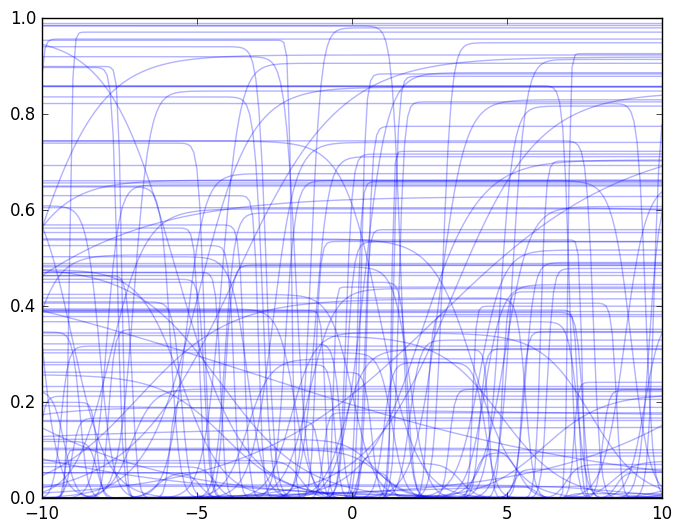

In [5]:
#Define a function that plots a logistic curve over the wide prior domain
function plot_logistic(slope,mid,max;col="blue",al=1)
    xvals = collect(-100:100)./10
    yvals = [logistic_func(x,slope,mid,max) for x in xvals]
    plot(xvals,yvals,color=col,alpha=al)
end

#Plot random prior logistic curves to visualize the prior distribution
for i in 1:200
    plot_logistic(randn()*10,randn()*10,rand(),al=0.3)
end

In [6]:
#MCMC itself. Should take about 30 seconds.
numreplicates = 1000000
oldslope,oldmid,oldmax = 0,0,0.5
oldLL = log_prior(oldslope,oldmid,oldmax)+loglikelihood(courses,oldslope,oldmid,oldmax)
slopes = zeros(numreplicates)
mids = zeros(numreplicates)
maxes = zeros(numreplicates)
LLs = zeros(numreplicates)
@time for i in 1:numreplicates
    newslope = oldslope+randn()*1.0
    newmid = oldmid+randn()*0.2
    newmax = oldmax+randn()*0.2
    #Need to catch the occurance of an out of bounds "max" parameter.
    if 0<newmax<1
        newLL = log_prior(newslope,newmid,newmax)+loglikelihood(courses,newslope,newmid,newmax)
    else
        newLL = -Inf
    end
    if rand() < e^(newLL-oldLL)
        oldslope,oldmid,oldmax = newslope,newmid,newmax
        oldLL = newLL
    end
    slopes[i] = oldslope
    mids[i] = oldmid
    maxes[i] = oldmax
    LLs[i] = oldLL
end

 31.894109 seconds (992.59 M allocations: 18.695 GiB, 4.64% gc time)


In [7]:
println("5%, 50%, and 95% parameter quantiles:")
println("slope: ",quantile(slopes[10000:10:end],[0.05,0.5,0.95]))
println("offset: ",quantile(mids[10000:10:end],[0.05,0.5,0.95]))
println("max: ",quantile(maxes[10000:10:end],[0.05,0.5,0.95]))
println("LL: ",quantile(LLs[10000:10:end],[0.05,0.5,0.95]))

5%, 50%, and 95% parameter quantiles:
slope: [-6.41536, -3.51483, -2.00765]
offset: [1.71947, 2.12447, 2.43952]
max: [0.599576, 0.802684, 0.961609]
LL: [-37.0309, -34.1271, -33.1867]


In [8]:
println("Effective Sample Sizes:")
println("ESS slope: ",round(effective_sample_size(slopes[10000:10:end]),2))
println("ESS offset: ",round(effective_sample_size(mids[10000:10:end]),2))
println("ESS max: ",round(effective_sample_size(maxes[10000:10:end]),2))
println("ESS LL: ",round(effective_sample_size(LLs[10000:10:end]),2))

Effective Sample Sizes:
ESS slope: 10950.0
ESS offset: 20433.92
ESS max: 30956.01
ESS LL: 19055.45


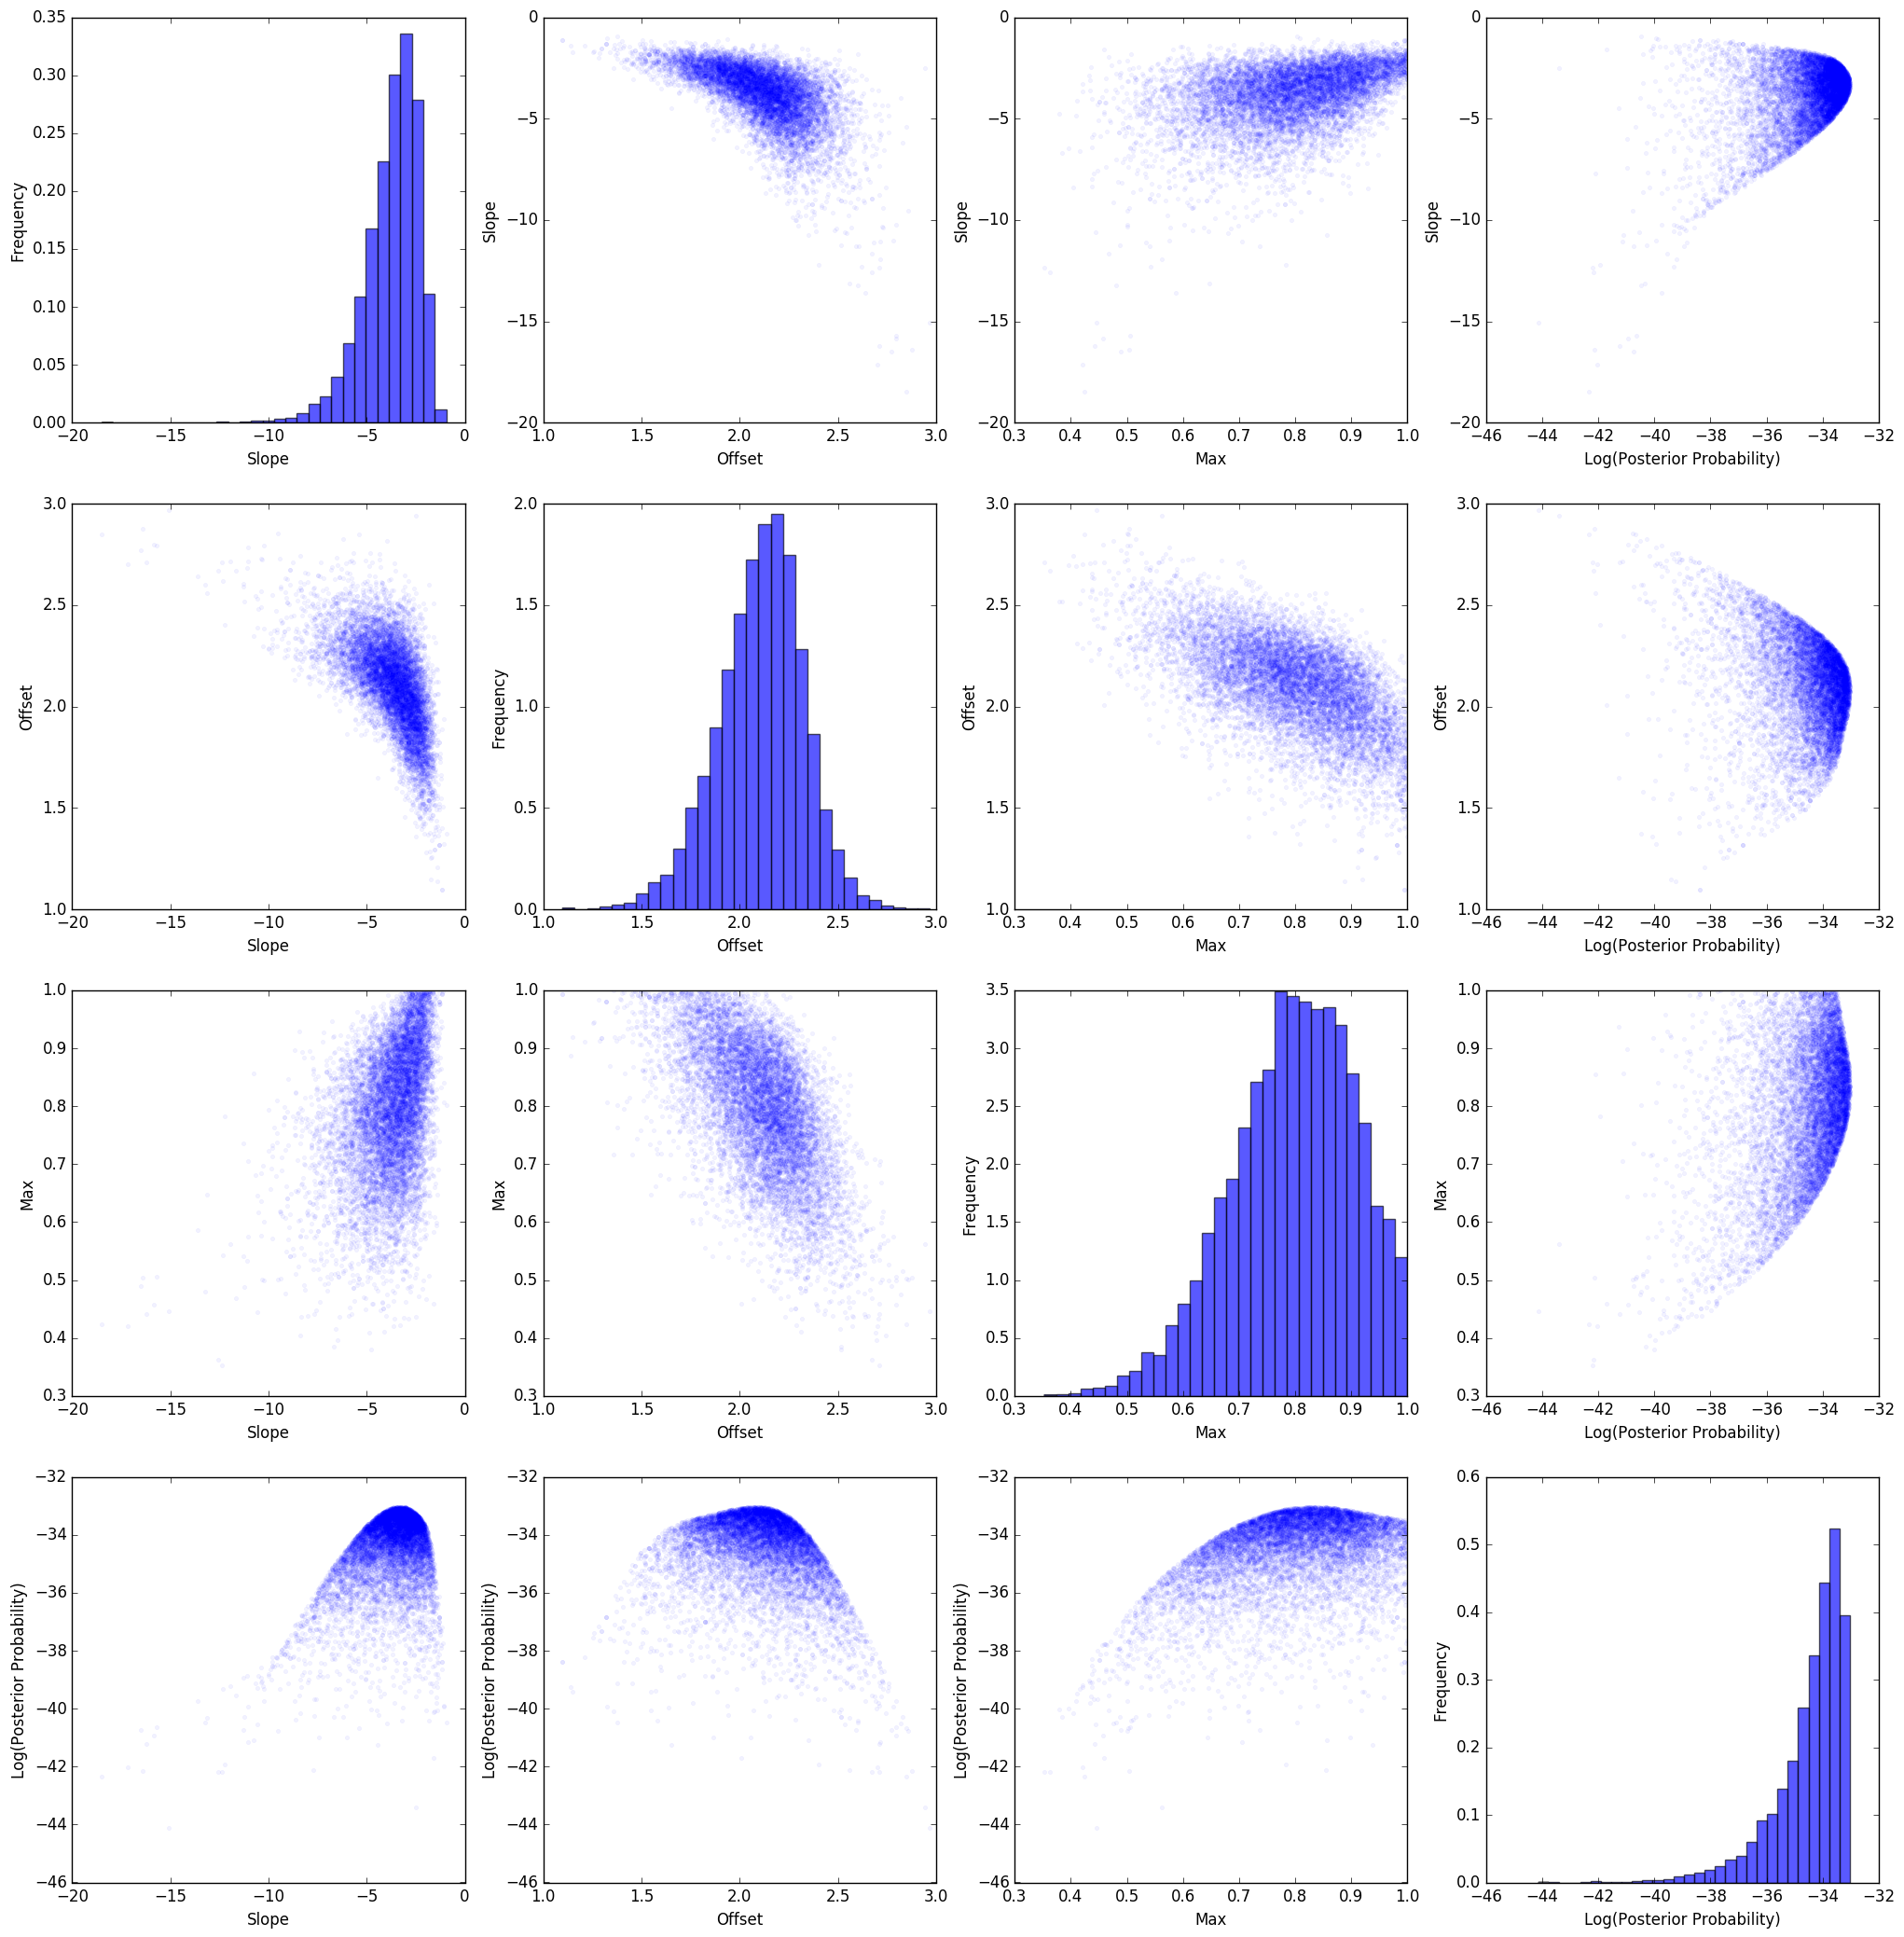

In [9]:
#Visualize the posterior distribution
selected = sample(10000:numreplicates,10000);
chainvec = [slopes[selected],mids[selected],maxes[selected],LLs[selected]];
namevec = ["Slope","Offset","Max","Log(Posterior Probability)"]
boundsvec = [()]

figure("pyplot_subplot_mixed",figsize=(25,25))
for i in 1:length(chainvec)
    for j in 1:length(chainvec)
        subplot(4,4,(i-1)*4+j)
        if i==j
            plt[:hist](chainvec[i],30,normed=true,color="blue",alpha=0.65)
            PyPlot.xlabel(namevec[i])
            PyPlot.ylabel("Frequency")
        else
            plot(chainvec[j],chainvec[i],".",alpha=0.05)
            PyPlot.xlabel(namevec[j])
            PyPlot.ylabel(namevec[i])
        end
        
    end
end

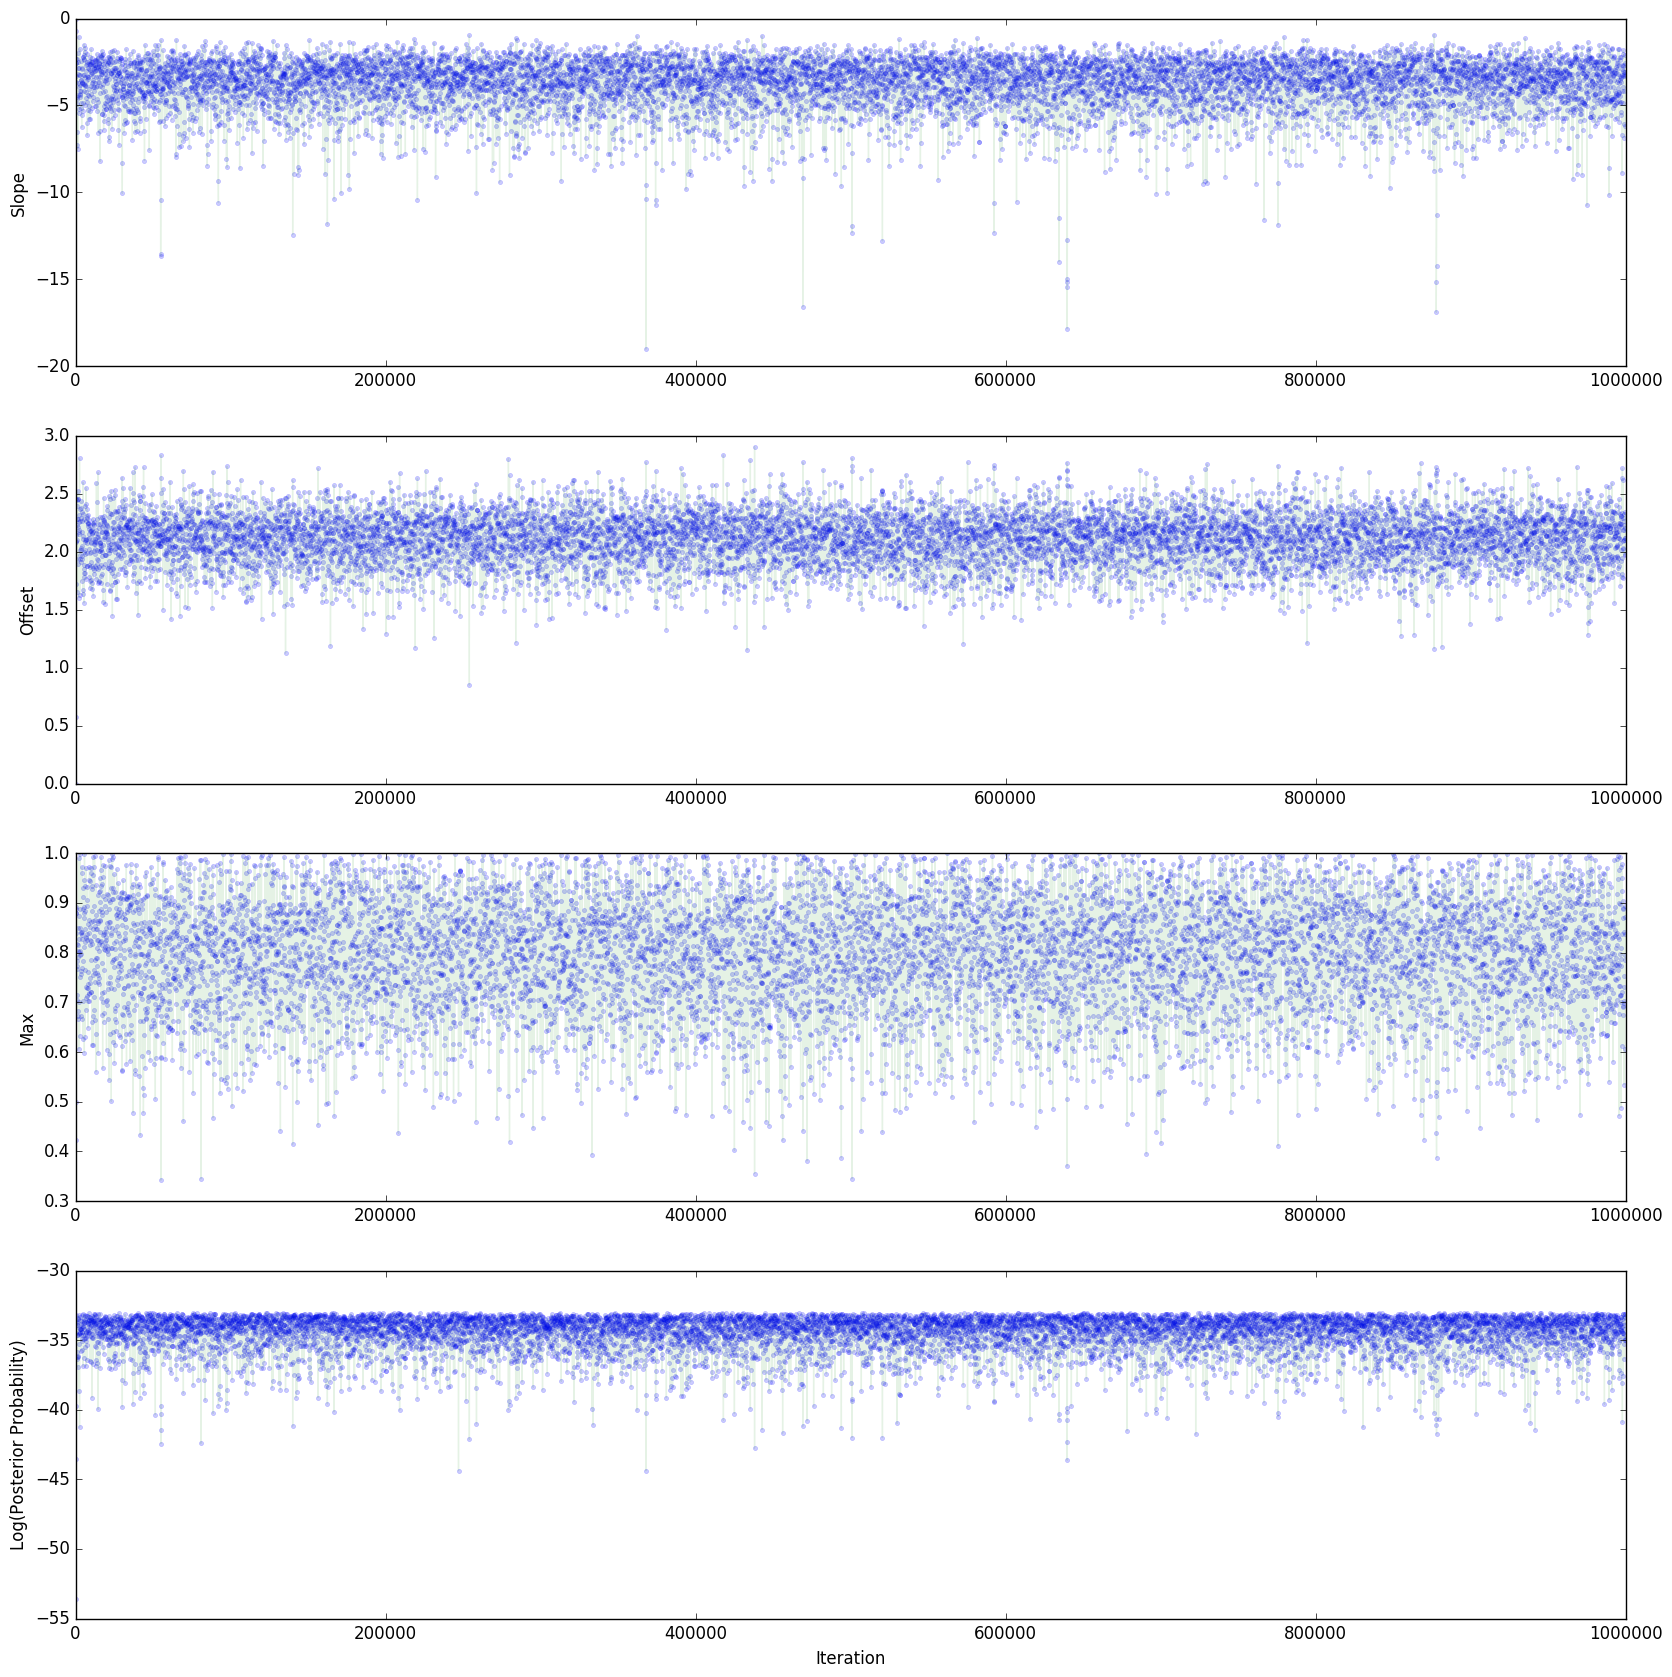

In [12]:
#Visualize the chain mixing
chainvec = [slopes,mids,maxes,LLs];
figure("pyplot_subplot_mixed",figsize=(20,20))
for i in 1:length(chainvec)
    subplot(4,1,i)
    plot(1:100:length(chainvec[i]),chainvec[i][1:100:end],".",alpha=0.2)
    plot(1:100:length(chainvec[i]),chainvec[i][1:100:end],alpha=0.1)
    PyPlot.ylabel(namevec[i])
end
PyPlot.xlabel("Iteration");

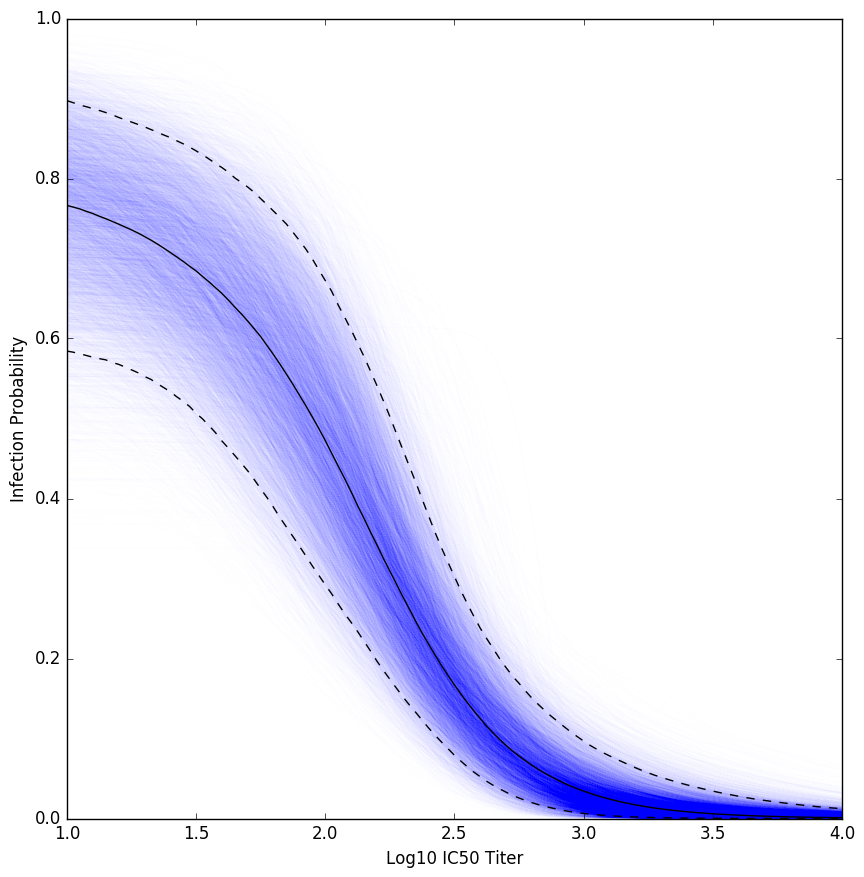

In [14]:
#Visualize the posterior sampled logistic curves
function plot_logistic(slope,mid,max;col="blue",al=1)
    xvals = collect(40:160)./40
    yvals = [logistic_func(x,slope,mid,max) for x in xvals]
    plot(xvals,yvals,color=col,alpha=al)
end

selected = sample(10000:numreplicates,10000);

figure(figsize=(10, 10))

for sel in selected
    plot_logistic(slopes[sel],mids[sel],maxes[sel],col="blue",al=0.002)
end

xvals = collect(40:160)./40
yvalArr = [[logistic_func(x,slopes[sel],mids[sel],maxes[sel]) for x in xvals] for sel in selected];
quantileCurves = [quantile([yvals[xpos] for yvals in yvalArr],[0.05,0.5,0.95]) for xpos in 1:length(xvals)];

plot(xvals,[quant[1] for quant in quantileCurves],color="black",linestyle="--")
plot(xvals,[quant[2] for quant in quantileCurves],color="black")
plot(xvals,[quant[3] for quant in quantileCurves],color="black",linestyle="--")
PyPlot.xlabel("Log10 IC50 Titer")
PyPlot.ylabel("Infection Probability");

In [13]:
#Exporting high quality quantile curves for plotting in mathematica.
selected = sample(10000:numreplicates,50000);
xvals = collect(40:160)./40
yvalArr = [[logistic_func(x,slopes[sel],mids[sel],maxes[sel]) for x in xvals] for sel in selected];
quantileCurves = [quantile([yvals[xpos] for yvals in yvalArr],[0.05,0.5,0.95]) for xpos in 1:length(xvals)];
#writetable("quantile_curves.csv",DataFrame([xvals,[quant[1] for quant in quantileCurves],[quant[2] for quant in quantileCurves],[quant[3] for quant in quantileCurves]]))